In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List
import seaborn as sns

### Đọc toàn bộ dữ liệu

In [3]:
dataset = pd.read_pickle('data/train/cars.pkl')
dataset["Năm sản xuất"] = 2024 - dataset["Năm sản xuất"]
dataset.rename(columns={"Năm sản xuất": "Tuối xe"}, inplace=True)
print(dataset.shape)
dataset.head()

(25582, 15)


,Tên hãng xe,Tuối xe,Tỉnh,Số Km đã đi,Xuất xứ,Kiểu dáng,Hộp số,Màu ngoại thất,Màu nội thất,Số chỗ ngồi,Số cửa,Dẫn động,Loại động cơ,Dung tích,Giá
0,audi,4,TP HCM,30.0,Nhập khẩu,Sedan,Số tự động,Đen,Đen,5,4,AWD,Xăng,3.0,2950.0
1,audi,10,Hà Nội,94.0,Nhập khẩu,Sedan,Số tự động,Xanh,Nâu,5,4,FWD,Xăng,2.0,560.0
2,audi,8,TP HCM,50.0,Nhập khẩu,Sedan,Số tự động,Đen,Đen,5,4,FWD,Xăng,2.0,690.0
3,audi,8,Hà Nội,76.0,Nhập khẩu,Crossover,Số tự động,Xanh,Đen,5,5,AWD,Xăng,2.0,699.0
4,audi,8,Hà Nội,90.0,Nhập khẩu,SUV,Số tự động,Trắng,Kem,5,5,AWD,Xăng,2.0,739.0


In [4]:
X = dataset.drop(columns=['Giá'], axis=1)
y = dataset['Giá']

Khai báo seed, test size để chia dữ liệu huấn luyện, kiểm thử giống nhau

In [5]:
SPLIT_SEED = 99
TEST_SIZE = .25

### Thiết kế hàm đánh giá mô hình dự đoán giá trị

Sử dụng 3 metrics chính để đánh giá sự hiệu quả của mô hình dự đoán:
- Mean Squared Error (MSE): Trung bình bình phương sai số, MSE càng nhỏ, mô hình càng tốt
- Mean Absolute Error (MAE): Trung bình giá trị tuyệt đối sai số. MAE càng nhỏ, mô hình càng tốt
- $R^2$ Score: Hệ số xác định, thể hiện mức độ phù hợp của mô hình với dữ liệu, giá trị nằm trong khoảng (0, 1)
$R^2 = 1 - \frac{SSR}{TSS}$ với SSR(sum of squared residuals): tổng bình phương sai số, và TSS(total sum of squares): tổng bình phương sự khác biệt giá trị thực tế và giá trị trung bình, $R^2 Score$ càng gần 1, thì mô hình giải thích tốt sự biến đổi trong dữ liệu

In [6]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, max_error

def evaluate(y_pred, y_test):
    np.set_printoptions(precision=0)
    values = np.concatenate((y_pred.reshape(-1, 1), y_test.reshape(-1, 1)), 1)
    print(values)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    max_err = max_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R^2 Score: {r2}")
    print(f"Max Error: {max_err}")

    plt.scatter(y_test, y_pred)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
    plt.show()
    return mse, mae, r2

### Thiết kế baseline bằng mô hình Linear Regression đơn giản

Mã hóa dữ liệu danh mục bằng LabelEncoder

In [7]:
from sklearn.preprocessing import LabelEncoder

def encode_label(dataset: pd.DataFrame, columns: List[str]) -> pd.DataFrame:
    dataset_encoded = dataset
    le = LabelEncoder()
    for col in columns:
        dataset_encoded[col] = le.fit_transform(dataset[col])
    return dataset_encoded

X_encoded = encode_label(
    X, 
    columns=[
        "Tên hãng xe", "Tỉnh", "Xuất xứ", "Kiểu dáng", "Hộp số", 
        "Màu ngoại thất", "Màu nội thất", "Dẫn động", "Loại động cơ"]
)
X_encoded

,Tên hãng xe,Tuối xe,Tỉnh,Số Km đã đi,Xuất xứ,Kiểu dáng,Hộp số,Màu ngoại thất,Màu nội thất,Số chỗ ngồi,Số cửa,Dẫn động,Loại động cơ,Dung tích
0,1,4,45,30.0,1,6,1,14,14,5,4,1,2,3.0
1,1,10,17,94.0,1,6,1,12,8,5,4,2,2,2.0
2,1,8,45,50.0,1,6,1,14,14,5,4,2,2,2.0
3,1,8,17,76.0,1,3,1,12,14,5,5,1,2,2.0
4,1,8,17,90.0,1,5,1,9,5,5,5,1,2,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26401,26,2,17,10.0,1,6,1,9,8,5,4,1,2,2.0
26402,26,2,17,13.0,1,6,1,9,8,5,4,1,2,2.0
26403,26,2,17,3.0,1,5,1,9,8,7,5,1,1,2.0
26404,26,3,17,50.0,1,6,1,13,14,5,4,1,2,2.0


Chia dữ liệu huấn luyện, kiểm thử

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=TEST_SIZE, random_state=SPLIT_SEED)
print(len(X_train), len(X_test))

19186 6396


Fit mô hình Linear Regression

[[1737. 1420.]
 [ 177.  365.]
 [1265.  465.]
 ...
 [ 599.  435.]
 [ 943.  540.]
 [1356. 3880.]]
Mean Squared Error: 1269197.838747904
Mean Absolute Error: 649.1141905700588
R^2 Score: 0.5475571881879541
Max Error: 19574.532043312705


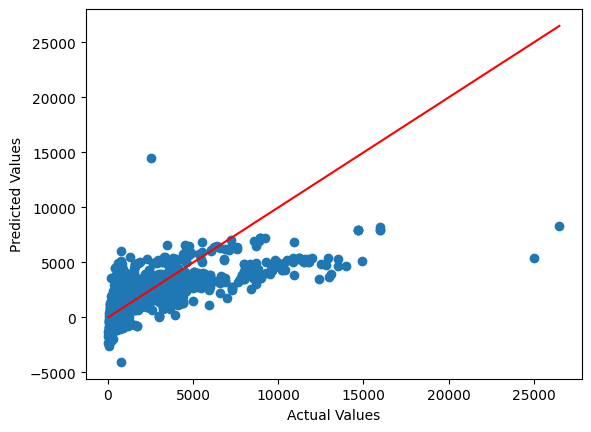

In [ ]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
_ = evaluate(y_pred, y_test.values)

## Ridge Regression (L2 Regularization)

[[1737. 1420.]
 [ 177.  365.]
 [1265.  465.]
 ...
 [ 599.  435.]
 [ 943.  540.]
 [1356. 3880.]]
Mean Squared Error: 1269198.701070219
Mean Absolute Error: 649.1113480792444
R^2 Score: 0.5475568807878617
Max Error: 19574.578489617452


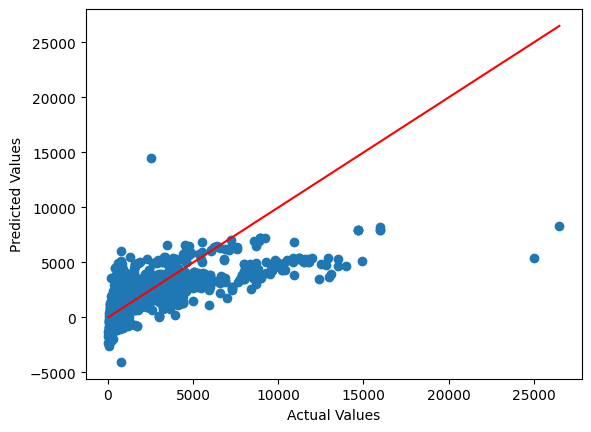

In [ ]:
from sklearn.linear_model import Ridge
regressor = Ridge(alpha=0.1)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
_ = evaluate(y_pred, y_test.values)

## Lasso Regression (L1 Regularization)

[[1737. 1420.]
 [ 177.  365.]
 [1265.  465.]
 ...
 [ 600.  435.]
 [ 944.  540.]
 [1357. 3880.]]
Mean Squared Error: 1269223.3595935006
Mean Absolute Error: 648.9947018824333
R^2 Score: 0.5475480905336806
Max Error: 19576.08498792292


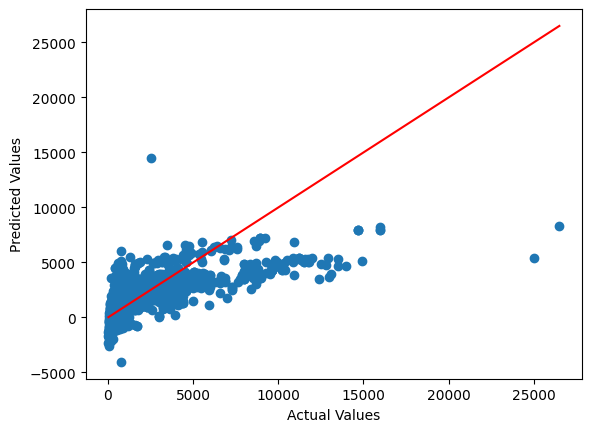

In [ ]:
from sklearn.linear_model import Lasso

regressor = Lasso(alpha=0.1)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
_ = evaluate(y_pred, y_test.values)

## Decision Tree Regression

[[1424. 1420.]
 [ 365.  365.]
 [ 490.  465.]
 ...
 [ 445.  435.]
 [ 548.  540.]
 [3990. 3880.]]
Mean Squared Error: 146329.42012023935
Mean Absolute Error: 89.8320146636366
R^2 Score: 0.9478365844403416
Max Error: 13470.0


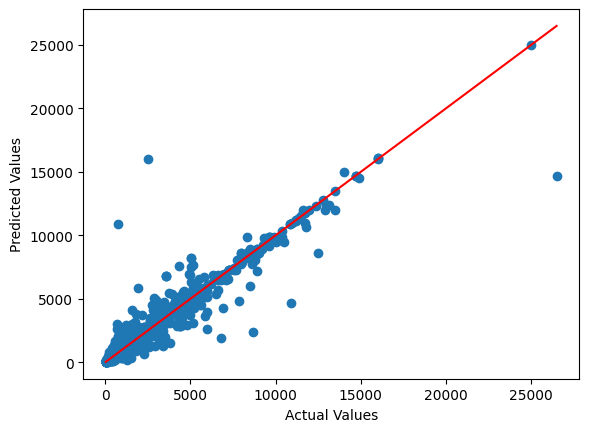

In [ ]:
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
_ = evaluate(y_pred, y_test.values)

In [ ]:
regressor.feature_importances_

array([7.e-02, 3.e-01, 2.e-03, 5.e-02, 3.e-02, 3.e-02, 5.e-04, 4.e-03,
       5.e-03, 2.e-02, 6.e-03, 4.e-02, 2.e-02, 5.e-01])

## Random Forest Regression

[[1423. 1420.]
 [ 354.  365.]
 [ 491.  465.]
 ...
 [ 431.  435.]
 [ 590.  540.]
 [3719. 3880.]]
Mean Squared Error: 120504.11172450791
Mean Absolute Error: 83.7178696292465
R^2 Score: 0.9570427734124288
Max Error: 12171.185


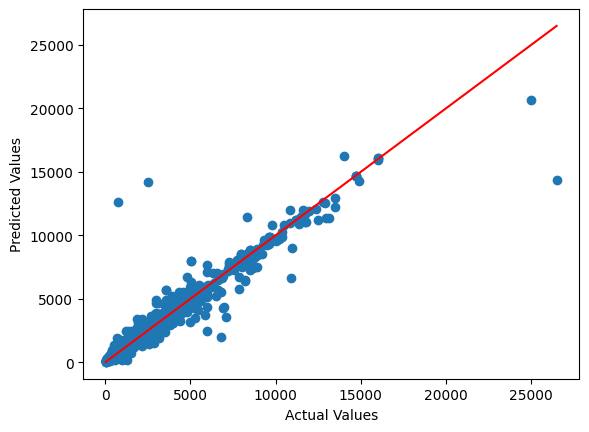

In [ ]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=100, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
_ = evaluate(y_pred, y_test.values)

Tối ưu hóa Random Forest bằng GridSearch

In [ ]:
# from sklearn.model_selection import GridSearchCV
# params = {
#     "criterion": ["squared_error", "friedman_mse", "poisson"],

# }
# regressor = RandomForestRegressor(random_state=1, n_estimators=100)

# optimizer = GridSearchCV(regressor, params, cv=5, n_jobs=-1, verbose=2)
# optimizer.fit(X_train.values, y_train.values)
# y_pred = optimizer.predict(X_test)
# _ = evaluate(y_pred, y_test.values)

In [ ]:
# regressor = RandomForestRegressor(
#     random_state=1,
#     criterion="poisson",
#     n_estimators=100,
#     max_leaf_nodes=16,
#     min_samples_split=10,
#     min_samples_leaf=10,
# )
# regressor.fit(X_train, y_train)

In [ ]:
# regressor.feature_importances_

In [ ]:
# feature_imp = pd.Series(
#     regressor.feature_importances_, index=X_train.columns
# ).sort_values(ascending=False)
# print(feature_imp)
# sns.barplot(x=feature_imp, y=feature_imp.index)
# # Add labels to your graph
# plt.xlabel("Feature Importance Score")
# plt.ylabel("Features")
# plt.title("Visualizing Important Features")

## K-Nearest Neighbors (KNN)

[[1424. 1420.]
 [ 334.  365.]
 [ 492.  465.]
 ...
 [ 462.  435.]
 [ 616.  540.]
 [3990. 3880.]]
Mean Squared Error: 225894.94204385552
Mean Absolute Error: 150.40763758599124
R^2 Score: 0.9194731194521506
Max Error: 13100.0


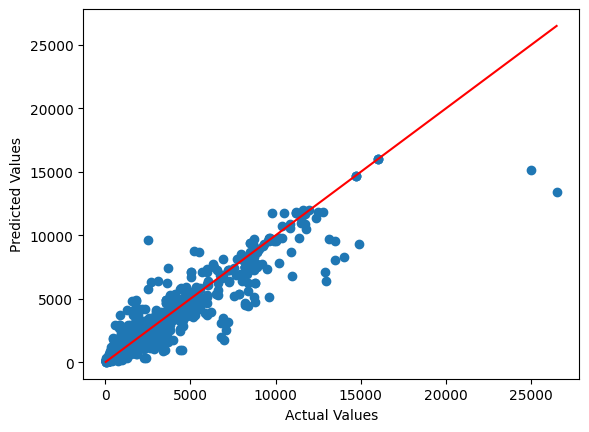

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

regressor = KNeighborsRegressor(n_neighbors=4)

regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
_ = evaluate(y_pred, y_test.values)

## Support Vector Regression

In [ ]:
from sklearn.svm import SVR

regressor = SVR(kernel='rbf')
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)
_ = evaluate(y_pred, y_test.values)

## Gradient Boosting Regression

[[1574. 1420.]
 [ 359.  365.]
 [ 611.  465.]
 ...
 [ 467.  435.]
 [1077.  540.]
 [2835. 3880.]]
Mean Squared Error: 339171.9467626106
Mean Absolute Error: 286.3903062654155
R^2 Score: 0.8790922072224538
Max Error: 14865.854040220807


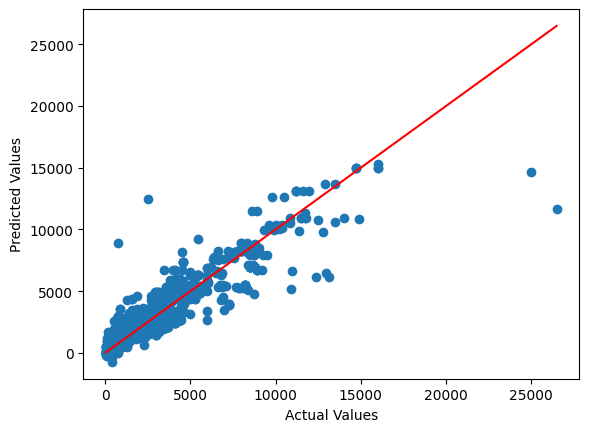

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

regressor = GradientBoostingRegressor()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)
_ = evaluate(y_pred, y_test.values)

### Bagging

[[1423. 1420.]
 [ 343.  365.]
 [ 491.  465.]
 ...
 [ 422.  435.]
 [ 633.  540.]
 [3429. 3880.]]
Mean Squared Error: 248943.36487430386
Mean Absolute Error: 148.31570261162665
R^2 Score: 0.9112568328222201
Max Error: 11728.318333333333


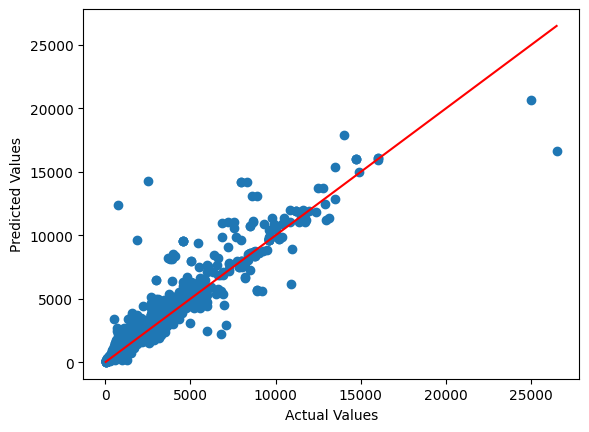

In [ ]:
from sklearn.ensemble import BaggingRegressor

regressor = DecisionTreeRegressor()
bagging = BaggingRegressor(estimator=regressor, n_estimators=100, random_state=0)
bagging.fit(X_train, y_train)
y_pred = bagging.predict(X_test)
_ = evaluate(y_pred, y_test.values)

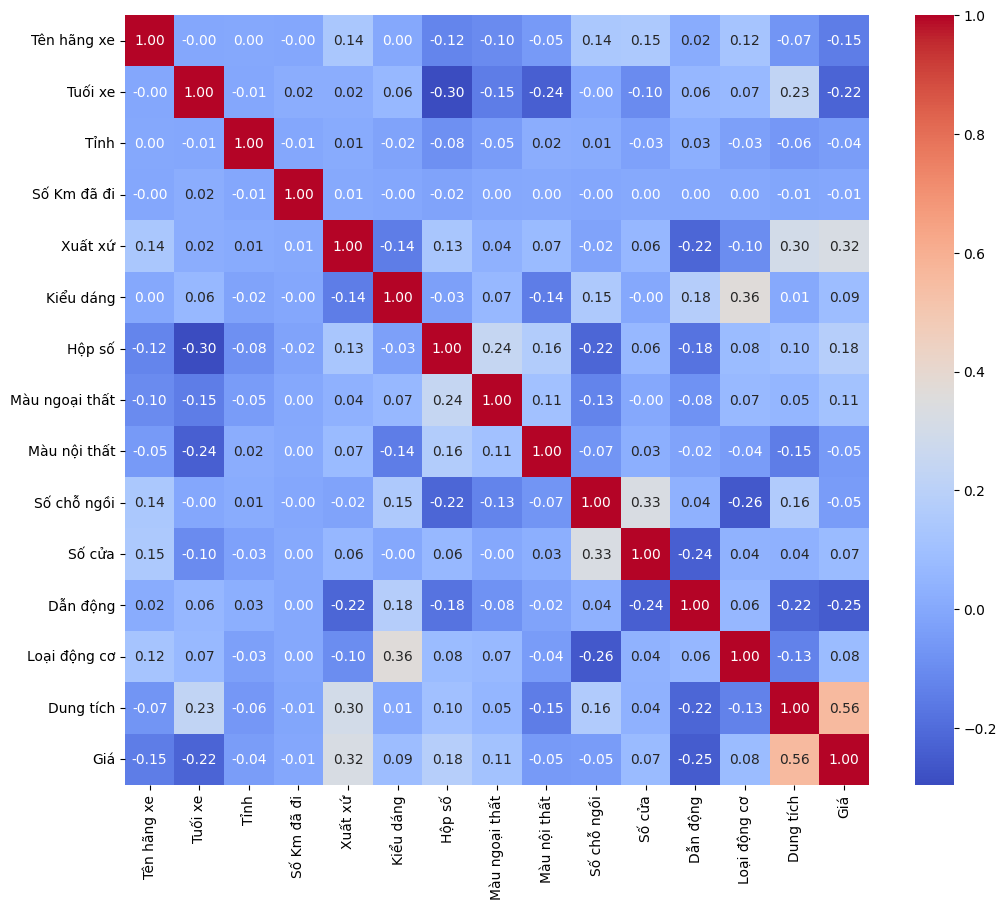

In [ ]:
corr_matrix = encode_label(
    dataset, 
    columns=[
        "Tên hãng xe", "Tỉnh", "Xuất xứ", "Kiểu dáng", "Hộp số", 
        "Màu ngoại thất", "Màu nội thất", "Dẫn động", "Loại động cơ"
    ]
).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

In [ ]:
# from sklearn.ensemble import RandomForestRegressor

# regressor = RandomForestRegressor(
#     max_depth=6, max_leaf_nodes=16, min_samples_split=10, min_samples_leaf=10
# )
# regressor.fit(X_train, y_train)
# y_pred = regressor.predict(X_test)
# _ = evaluate(y_pred, y_test.values)

In [ ]:
# regressor.feature_importances_